In [1]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pickle
from pathlib import Path
from datetime import datetime
from datetime import timedelta

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})

In [4]:
pd.read_csv('./2022-10-31-NU_UCSD-FLUH.csv')

,forecast_date,target,target_end_date,location,type,quantile,value
0,2022-10-31,1 wk ahead inc flu hosp,2022-11-05,23,point,NaN,6.056970
1,2022-10-31,1 wk ahead inc flu hosp,2022-11-05,23,quantile,0.50,6.053431
2,2022-10-31,1 wk ahead inc flu hosp,2022-11-05,23,quantile,0.55,6.236297
3,2022-10-31,1 wk ahead inc flu hosp,2022-11-05,23,quantile,0.60,6.404808
4,2022-10-31,1 wk ahead inc flu hosp,2022-11-05,23,quantile,0.65,6.636376
...,...,...,...,...,...,...,...
91,2022-11-21,4 wk ahead inc flu hosp,2022-11-26,23,quantile,0.25,16.343275
92,2022-11-21,4 wk ahead inc flu hosp,2022-11-26,23,quantile,0.30,20.013004
93,2022-11-21,4 wk ahead inc flu hosp,2022-11-26,23,quantile,0.35,23.418743
94,2022-11-21,4 wk ahead inc flu hosp,2022-11-26,23,quantile,0.40,24.317720


In [9]:
import matplotlib.dates as mdates
def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)

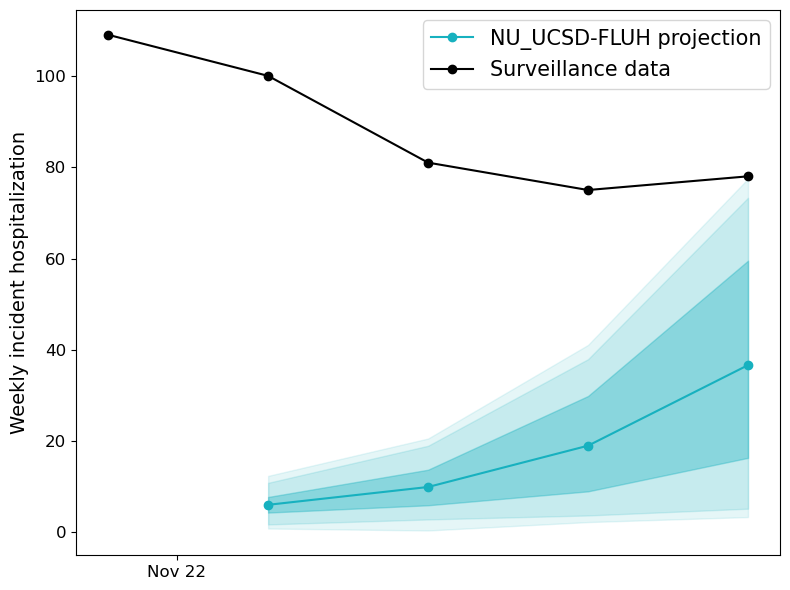

In [57]:
#model = 'Ensemble_LOP'

#predalllist = [predictions_flusmh_rd1, predictions_flusmh_rd2]
predictions = pd.read_csv('./2022-10-31-NU_UCSD-FLUH.csv')
predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])


start_week = Week(2022,43)
end_week = Week(2022,47)

max_date=None
#max_date = pd.to_datetime('2023-06-03')

#max_date_pred = pd.to_datetime('2024-01-01')

map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1

incidence = True
target = 'hosp'
target_location = '23'

if target == 'hosp':
    target_obs = 'hospitalization'
elif target == 'death':
    target_obs = 'death_new'
else:
    target_obs = target
    
loclist = list(predictions.location.unique())

observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])

#filter start - end week
observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & 
                            (observations['date'] <= pd.to_datetime(end_week.enddate()))]

#filter location
observations = observations[observations['location'] == target_location]

#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

if max_date:
    observations = observations[observations['date'] <= max_date].copy()

#transform to Observation object
observations = Observations(observations)

target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} flu {target}" for i in range(1,100)]
       
# Setting up the plot surface
fig,ax0 = plt.subplots(figsize=(8, 6))
ind =0
colors = ['#17B1BF', '#ff7f27']

pred = predictions[predictions.location == int(target_location)]

#pred  = pred[pred.target == '4 wk ahead inc flu hosp']

#pred = pred[(pred['target'].isin(target_prediction_list))]

if max_date:
    pred = pred[pred['target_end_date'] <= max_date]

if len(pred) == 0:
    raise RuntimeError(f"There are no predictions for model at location {target_location}")

intervals = [(0.01,0.99),(0.05,0.95),(0.25,0.75)]

preds = Predictions(pred, t_col = 'target_end_date')

t = np.unique(preds.get_t())

#intervals
for interval in intervals:
    q_low,q_upp = interval
    interval_range = q_upp - q_low
    alpha = map_alpha(interval_range)
    pred_low = preds.get_quantile(q_low)
    pred_upp = preds.get_quantile(q_upp)
    plt.fill_between(t,pred_upp,pred_low, color=colors[ind], alpha=alpha)
#if i == 0 and j == 0:
#    axes[i][j].legend(frameon=True, fontsize=fontsize)

#point estimate
pred_point = preds.get_point()
if len(pred_point) > 0:
    plt.plot(t,pred_point,'-o',color=colors[ind], label = 'NU_UCSD-FLUH projection')

ind+=1

#plot surveillance
plt.plot(list(observations.get_t()),list(observations.get_value()),'-o', color='k', label='Surveillance data')


#set y axis 
plt.ylabel(f"Weekly {'incident' if incidence else 'cumulative'} {target_obs}", fontsize=14)


#plt.ylim([0,maxi+100])
ax0.tick_params(labelsize=12)

#fig.suptitle(fr"{model},  target = {target_obs}, location = {target_location}", fontsize=fontsize+4) 

set_date_axis_fmt(ax0)

plt.legend(frameon=True, fontsize=15, loc='upper right')

#fig.suptitle(r"\textbf"+"{"+f"{model}, Round {rd}, target = {target}, location = {location_mapping[target_location]}"+"}", fontsize=fontsize+4)

plt.tight_layout()
#plt.savefig('ensemblelopflusmh_time.pdf')
plt.show()

In [77]:
# timestamped WIS values
# regular wis, not normalized/rescaled

target = 'hosp'
ind = 0

predrd = pd.read_csv('./2022-10-31-NU_UCSD-FLUH.csv')
predrd['Model'] = 'NU_UCSD-FLUH'

loclist = predrd.location.unique()

startdates = [Week(2022, 44), Week(2022, 45), Week(2022, 46), Week(2022, 47)]

#start_week = Week(2022, 42)
#end_week = Week(2023, 23)
#max_date = None

models = list(predrd.Model.unique())

i = 0

df = pd.DataFrame()

for date in startdates:
    start_week = date.enddate()
    #end_week = enddates[i]
    
    predics = predrd.copy()
    predics['target_end_date'] = pd.to_datetime(predics['target_end_date'])
    predics = predics[predics.target_end_date == pd.to_datetime(start_week)]

    i +=1
    for l in loclist:

        incidence = True
        target_location = l

        if target == 'hosp':
            target_obs = 'hospitalization'
        else:
            target_obs = target

        observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
        observations['date'] = pd.to_datetime(observations['date'])

        #filter start - end week
        observations = observations[(observations['date'] == pd.to_datetime(start_week)) ]

        #filter location
        observations = observations[observations['location'] == str(target_location)]

        #aggregate to weekly
        observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

        #transform to Observation object
        observations = Observations(observations)

        
        locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})
        location_mapping = dict()

        for loc in locations['location']:
            location_mapping[loc] = locations[locations['location'] == loc]['abbreviation'].unique()[0]

        target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} flu {target}" for i in range(1,5)]

        for model in models:    
            try:
                predictions = predics[predics.Model == model]
                predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
                predictions = predictions[predictions.location != 'US']
                predictions = predictions.astype({'location':'int'})

                locations = locations[locations.location != 'US']
                locations = locations.astype({'location':'int'})

                predictions = predictions.merge(locations, how='inner', on='location')

                target_locations = int(target_location)

                pred = predictions[predictions['location'] == int(target_location)].copy()

                #filter target
                pred = pred[(pred['target'].isin(target_prediction_list))]

                
                if len(pred) == 0:
                        
                    raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")
                    #continue
                
                for tweek in target_prediction_list:
                    label=tweek

                    prednew = pred[pred.target == tweek]
                    
                    if len(prednew) == 0:
                        continue

                    aggregated_scores = dict()

                    d = score_utils.all_timestamped_scores_from_df(observations, Predictions(prednew, t_col='target_end_date'))

                    #break

                    aggregated_scores[label] = d

                    agg_data_df = pd.DataFrame()
                    agg_data_df['Model'] = [model]
                    agg_data_df['WIS'] = aggregated_scores[label]['wis']

                    wisval = agg_data_df.WIS[0]

                    locname = list(pred.location_name.unique())[0]


                    new_row = {'Model':model, 'WIS':wisval,'Location': locname,'Date':start_week, 
                               'Label':label, 'Target':target}

                    df = df.append(new_row, ignore_index=True)


            except Exception as e:
                print(e) 
        
        #df.to_pickle(f'allmodel_wis_{target}_rd{rd}_525_all.pkl')  
        # raw WIS scores for all rounds/models/targets/locations

In [78]:
df

,Model,WIS,Location,Date,Label,Target
0,NU_UCSD-FLUH,1.670696,Maine,2022-11-05,1 wk ahead inc flu hosp,hosp
1,NU_UCSD-FLUH,3.081380,Maine,2022-11-12,2 wk ahead inc flu hosp,hosp
2,NU_UCSD-FLUH,5.023014,Maine,2022-11-19,3 wk ahead inc flu hosp,hosp
3,NU_UCSD-FLUH,13.371156,Maine,2022-11-26,4 wk ahead inc flu hosp,hosp


In [82]:
df_flusight_wis = pd.read_pickle(f'/Users/bay.c/Desktop/netsi/flu22_23/flusight_WISvalues.pkl')

In [83]:
df_flusight_wis

,Model,WIS,Location,Date,Label,Target
0,Flusight-baseline,39.803478,Alabama,2022-10-22,1 wk ahead inc flu hosp,hosp
1,Flusight-ensemble,34.906074,Alabama,2022-10-22,1 wk ahead inc flu hosp,hosp
2,MOBS-GLEAM_FLUH,61.868733,Alabama,2022-10-22,1 wk ahead inc flu hosp,hosp
3,Flusight-baseline,1.515652,Alaska,2022-10-22,1 wk ahead inc flu hosp,hosp
4,Flusight-ensemble,0.766890,Alaska,2022-10-22,1 wk ahead inc flu hosp,hosp
...,...,...,...,...,...,...
18687,Flusight-ensemble,2.558155,Wisconsin,2023-06-10,4 wk ahead inc flu hosp,hosp
18688,MOBS-GLEAM_FLUH,3.561522,Wisconsin,2023-06-10,4 wk ahead inc flu hosp,hosp
18689,Flusight-baseline,1.433043,Wyoming,2023-06-10,4 wk ahead inc flu hosp,hosp
18690,Flusight-ensemble,0.294080,Wyoming,2023-06-10,4 wk ahead inc flu hosp,hosp


In [91]:
#df = df.merge(locations, how='inner', on='location')

a = df_flusight_wis[df_flusight_wis.Label == '1 wk ahead inc flu hosp']

fdate = list(a.Date.unique())

refmodels = ["Flusight-baseline", "Flusight-ensemble", "MOBS-GLEAM_FLUH"]

dfratios_wis = pd.DataFrame()
for forecast in fdate:
    predweeks = df_flusight_wis.copy()
    
    weeks = [0,1,2,3]
    
    for wk in weeks:
        date = forecast + timedelta(days = 7*wk)
        pred = predweeks[predweeks.Date == date]
        
        dfmerge = pd.DataFrame()
        for ref in refmodels:
            predmod = pred[pred.Model == ref]
            
            #locs = list(predmod.Location.unique())
            
            for loc in ['Maine']:
                preddf = predmod[predmod.Location == loc]
                
                for model in ['NU_UCSD-FLUH']:
                    dfsmhmod = df[(df.Model == model) & (df.Location== loc) &(df.Date == pd.to_datetime(date))]
                    
                    
                    if len(dfsmhmod ) != 0:
                        df1 = dfsmhmod.copy()
                        
                        
                        dfmerge = df1.merge(preddf, how='inner', on='Location')
                        
                        
                        dfmerge['WIS_ratio'] = dfmerge['WIS_x'] / dfmerge['WIS_y']
                        
                        dfratios_wis = pd.concat([dfratios_wis, dfmerge])
        

In [92]:
dfratios_wis

,Model_x,WIS_x,Location,Date_x,Label_x,Target_x,Model_y,WIS_y,Date_y,Label_y,Target_y,WIS_ratio
0,NU_UCSD-FLUH,1.670696,Maine,2022-11-05,1 wk ahead inc flu hosp,hosp,Flusight-baseline,0.517391,2022-11-05,1 wk ahead inc flu hosp,hosp,3.229076
1,NU_UCSD-FLUH,1.670696,Maine,2022-11-05,1 wk ahead inc flu hosp,hosp,Flusight-baseline,1.250000,2022-11-05,2 wk ahead inc flu hosp,hosp,1.336556
2,NU_UCSD-FLUH,1.670696,Maine,2022-11-05,1 wk ahead inc flu hosp,hosp,Flusight-baseline,1.302609,2022-11-05,3 wk ahead inc flu hosp,hosp,1.282577
0,NU_UCSD-FLUH,1.670696,Maine,2022-11-05,1 wk ahead inc flu hosp,hosp,Flusight-ensemble,0.740163,2022-11-05,1 wk ahead inc flu hosp,hosp,2.257200
1,NU_UCSD-FLUH,1.670696,Maine,2022-11-05,1 wk ahead inc flu hosp,hosp,Flusight-ensemble,1.064460,2022-11-05,2 wk ahead inc flu hosp,hosp,1.569524
...,...,...,...,...,...,...,...,...,...,...,...,...
1,NU_UCSD-FLUH,13.371156,Maine,2022-11-26,4 wk ahead inc flu hosp,hosp,Flusight-ensemble,14.872401,2022-11-26,2 wk ahead inc flu hosp,hosp,0.899058
2,NU_UCSD-FLUH,13.371156,Maine,2022-11-26,4 wk ahead inc flu hosp,hosp,Flusight-ensemble,23.933941,2022-11-26,3 wk ahead inc flu hosp,hosp,0.558669
3,NU_UCSD-FLUH,13.371156,Maine,2022-11-26,4 wk ahead inc flu hosp,hosp,Flusight-ensemble,24.741130,2022-11-26,4 wk ahead inc flu hosp,hosp,0.540442
0,NU_UCSD-FLUH,13.371156,Maine,2022-11-26,4 wk ahead inc flu hosp,hosp,MOBS-GLEAM_FLUH,22.794487,2022-11-26,1 wk ahead inc flu hosp,hosp,0.586596


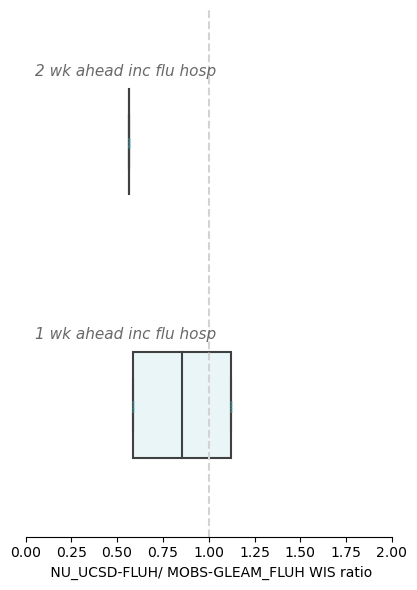

In [113]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(121)

df = dfratios_wis

df = df[(df.Model_x =='NU_UCSD-FLUH') & (df.Model_y == 'MOBS-GLEAM_FLUH')]


my_order = df.groupby(by=['Label_y'])['WIS_ratio'].median().sort_values(ascending=True).index
g = sns.boxplot(x='WIS_ratio', y='Label_y', data=df,order=my_order, color = '#17B1BF',width=.4, showfliers=False)

plt.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'lightgray', alpha=1)
for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .1))

    
sns.swarmplot(x='WIS_ratio', y='Label_y', data=df,order=my_order,color = "#49AFB7",
              alpha = .5,size=2, orient="h")    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

plt.xlabel(fr' NU_UCSD-FLUH/ MOBS-GLEAM_FLUH WIS ratio', fontsize=10)


plt.xlim([0,2]) # cuts off some outliers

a = 0
for mod in list(my_order):
    plt.text(0.05,a-.25, mod, fontsize=11, style='italic', color='dimgray')
    a+=1
    
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)


#plt.xscale("log")

#plt.suptitle(r'Rescaled WIS values for Death Predictions, all Rounds and Locations', fontsize=14)
plt.tight_layout()
#plt.savefig('baselinecomp_WISvals_flusight_lop_821.pdf')
plt.show()